In [62]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import hdbscan
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

**Data Importing**

In [63]:
# Load the dataset
data = pd.read_csv('player_features_cleaned.csv')

# Basic checks
print("Shape:", data.shape)
print("\nColumns:\n", data.columns.tolist())
print("\nData types & non‐null counts:")
print(data.info())

# Quick summary statistics
print("\nSummary statistics:")
print(data.describe().T)

# Check for missing values
missing = data.isnull().sum()
print("\nMissing values per column:")
if missing.sum() == 0:
    print("No missing values found.")
else:
    print(missing[missing > 0])


Shape: (2065, 56)

Columns:
 ['college', 'season', 'player_number_ind', 'player_ind', 'gp_ind', 'gs_ind', 'minutes_tot_ind', 'scoring_pts_ind', 'rebounds_tot_ind', 'ast_ind', 'stl_ind', 'blk_ind', 'to_ind', 'pts_per40', 'reb_per40', 'ast_per40', 'stl_per40', 'blk_per40', 'tov_per40', 'eFG_pct', 'TS_pct', 'USG_pct', 'ORB_pct', 'DRB_pct', 'AST_pct', 'AST_per_TO', '2pt_pct', 'FTr', 'PPP', 'possessions', 'scoring_pts_per100', 'ast_per100', 'rebounds_tot_per100', 'stl_per100', 'blk_per100', 'to_per100', 'mins_per_game', 'pts_per_game', 'ast_per_game', 'reb_per_game', 'stl_per_game', 'blk_per_game', 'to_per_game', 'scoring_pts_share', 'ast_share', 'rebounds_tot_share', 'stl_share', 'blk_share', 'to_share', 'team_TS_pct', 'TS_diff', 'ast_per_fgm', 'tov_rate', 'game_score', 'game_score_per40', 'min_share']

Data types & non‐null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2065 entries, 0 to 2064
Data columns (total 56 columns):
 #   Column               Non-Null Count  Dtype  
--

**Histograms, Density Plots and Box Plots**

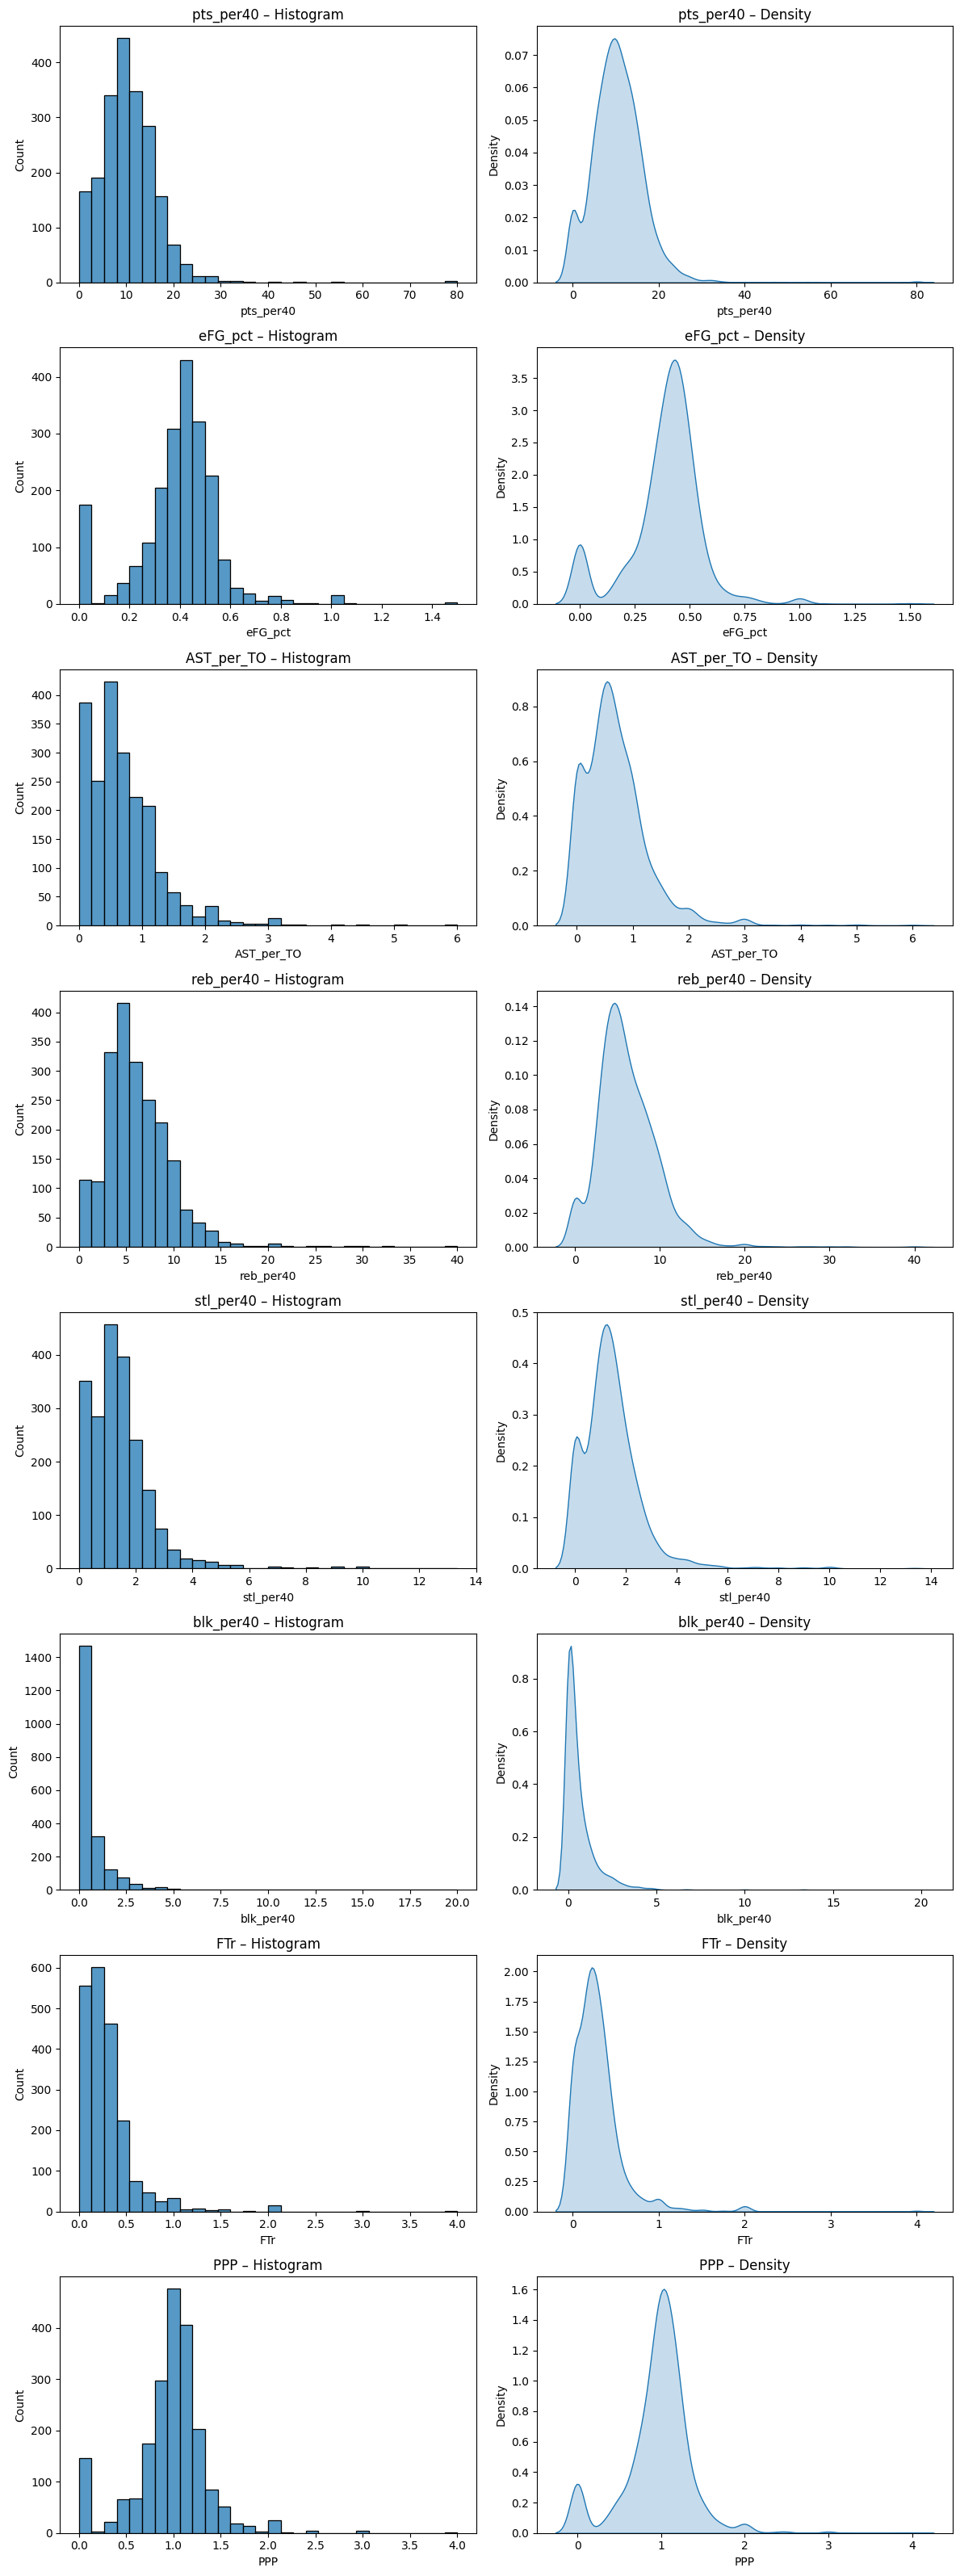

In [64]:
# Histograms & density plots for selected features
features = [
    'pts_per40','eFG_pct','AST_per_TO','reb_per40',
    'stl_per40','blk_per40','FTr','PPP'
]

fig, axes = plt.subplots(len(features), 2, figsize=(12, 4*len(features)))

for ax_row, col in zip(axes, features):
    sns.histplot(data[col], bins=30, ax=ax_row[0], kde=False)
    ax_row[0].set_title(f"{col} – Histogram")
    
    sns.kdeplot(data[col], fill=True, ax=ax_row[1])
    ax_row[1].set_title(f"{col} – Density")

plt.tight_layout()


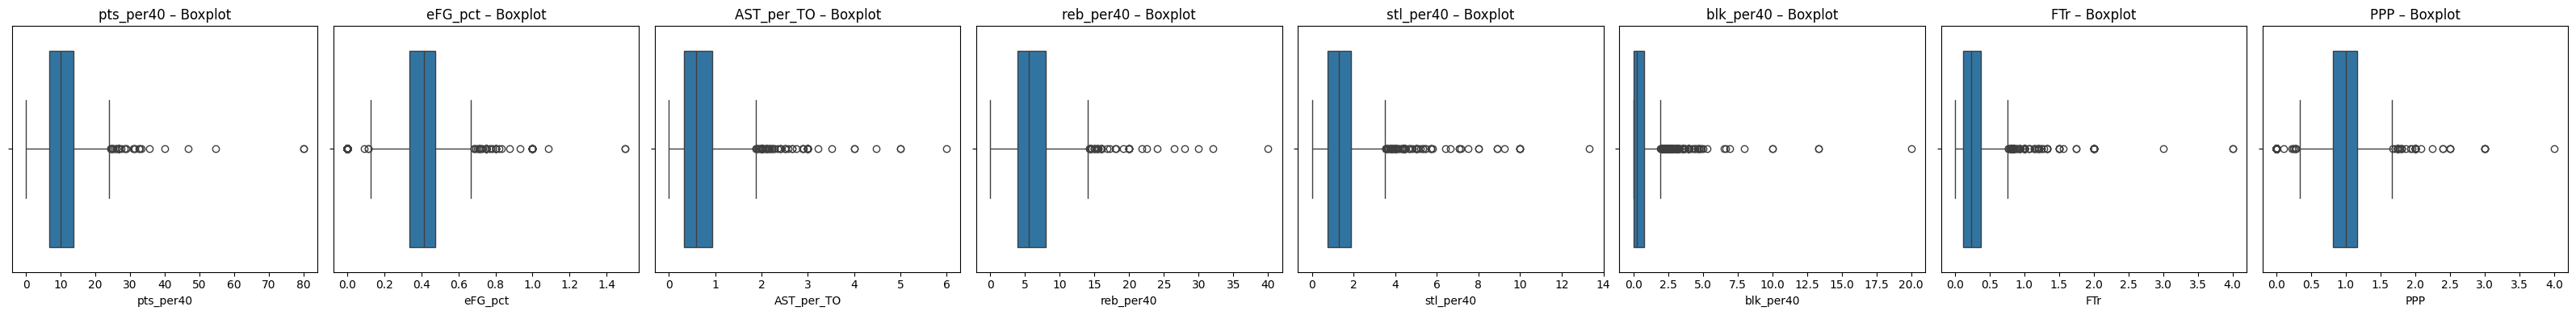

In [65]:
# Boxplots to spot outliers in the same features
fig, axes = plt.subplots(1, len(features), figsize=(4*len(features), 4), sharey=True)

for ax, col in zip(axes, features):
    sns.boxplot(x=data[col], ax=ax)
    ax.set_title(f"{col} – Boxplot")

plt.tight_layout()


**Data Smoothing and Manipulation**

In [66]:
# Make a working copy
df_clean = data.copy()
print("Starting shape:", df_clean.shape)


Starting shape: (2065, 56)


In [67]:
# Filter out very low-minute players 
# Drop any season‐rows where total minutes < 250 (common theresholdused by basketball analysts)
df_clean = df_clean[df_clean['minutes_tot_ind'] >= 250].reset_index(drop=True)
print("After minutes filter:", df_clean.shape)


After minutes filter: (1181, 56)


In [68]:
# Log1p‐transform heavily skewed volume stats 
skew_cols = ['pts_per40','reb_per40','stl_per40','blk_per40','FTr','PPP']
for c in skew_cols:
    df_clean[c] = np.log1p(df_clean[c])
print("Applied log1p to:", skew_cols)


Applied log1p to: ['pts_per40', 'reb_per40', 'stl_per40', 'blk_per40', 'FTr', 'PPP']


In [69]:
# Impute NaNs for rate/stat columns 
# Treat zero‐attempt players as missing, then fill with median
rate_cols = ['eFG_pct','TS_pct','AST_per_TO']
for c in rate_cols:
    df_clean.loc[df_clean[c] == 0, c] = np.nan
    median = df_clean[c].median()
    df_clean[c] = df_clean[c].fillna(median)
print("Imputed zeros->NaN, then filled medians for:", rate_cols)


Imputed zeros->NaN, then filled medians for: ['eFG_pct', 'TS_pct', 'AST_per_TO']


In [70]:
# Scale all numeric features (excluding player_number_ind)
# get all numeric columns except the ID
numeric_cols = [
    c for c in df_clean.select_dtypes(include=[np.number]).columns
    if c != 'player_number_ind'
]

# fit & transform only those
scaler = StandardScaler()
df_clean[numeric_cols] = scaler.fit_transform(df_clean[numeric_cols])

print("Scaled numeric columns (player_number_ind kept intact):")
print(numeric_cols)
df_clean.head()


Scaled numeric columns (player_number_ind kept intact):
['gp_ind', 'gs_ind', 'minutes_tot_ind', 'scoring_pts_ind', 'rebounds_tot_ind', 'ast_ind', 'stl_ind', 'blk_ind', 'to_ind', 'pts_per40', 'reb_per40', 'ast_per40', 'stl_per40', 'blk_per40', 'tov_per40', 'eFG_pct', 'TS_pct', 'USG_pct', 'ORB_pct', 'DRB_pct', 'AST_pct', 'AST_per_TO', '2pt_pct', 'FTr', 'PPP', 'possessions', 'scoring_pts_per100', 'ast_per100', 'rebounds_tot_per100', 'stl_per100', 'blk_per100', 'to_per100', 'mins_per_game', 'pts_per_game', 'ast_per_game', 'reb_per_game', 'stl_per_game', 'blk_per_game', 'to_per_game', 'scoring_pts_share', 'ast_share', 'rebounds_tot_share', 'stl_share', 'blk_share', 'to_share', 'team_TS_pct', 'TS_diff', 'ast_per_fgm', 'tov_rate', 'game_score', 'game_score_per40', 'min_share']


,college,season,player_number_ind,player_ind,gp_ind,gs_ind,minutes_tot_ind,scoring_pts_ind,rebounds_tot_ind,ast_ind,...,stl_share,blk_share,to_share,team_TS_pct,TS_diff,ast_per_fgm,tov_rate,game_score,game_score_per40,min_share
0,manhattan,2017-18,35,Kayla Grimme,0.671799,1.150887,1.199100,2.093976,2.656210,-0.208099,...,-0.306951,3.207118,0.768883,-0.023079,0.496781,-0.721489,-1.064766,2.373485,2.051238,1.226982
1,manhattan,2017-18,15,Amani Tatum,0.671799,1.241175,1.569857,1.595968,0.362534,2.833843,...,2.880269,-0.748228,1.775072,-0.023079,1.034088,0.448413,-0.081303,1.678842,1.000234,1.571821
2,manhattan,2017-18,2,Gabby Cajou,0.671799,-1.467469,1.050798,0.379522,-0.534991,2.020651,...,1.946084,-0.601734,0.809130,-0.023079,1.165036,0.547098,0.386057,0.613273,0.219941,1.089046
3,manhattan,2017-18,30,Mikki Guiton,0.450675,-0.564588,-0.749431,-0.485869,-0.568233,-1.051410,...,-1.131232,-0.674981,-0.961762,-0.023079,-0.406443,-0.823222,-0.875892,-0.742292,-0.597552,-0.644421
4,manhattan,2017-18,14,Taylor Williams,0.450675,0.518870,0.016799,-0.681807,-0.235816,-0.418927,...,-0.581711,-0.894723,-0.881267,-0.023079,-1.196982,-0.030860,-0.629134,-0.562128,-0.737723,0.045258


In [71]:
# final shape check
print("Final shape after all cleaning steps:", df_clean.shape)

Final shape after all cleaning steps: (1181, 56)


Visualise Density and Histrogram plots again

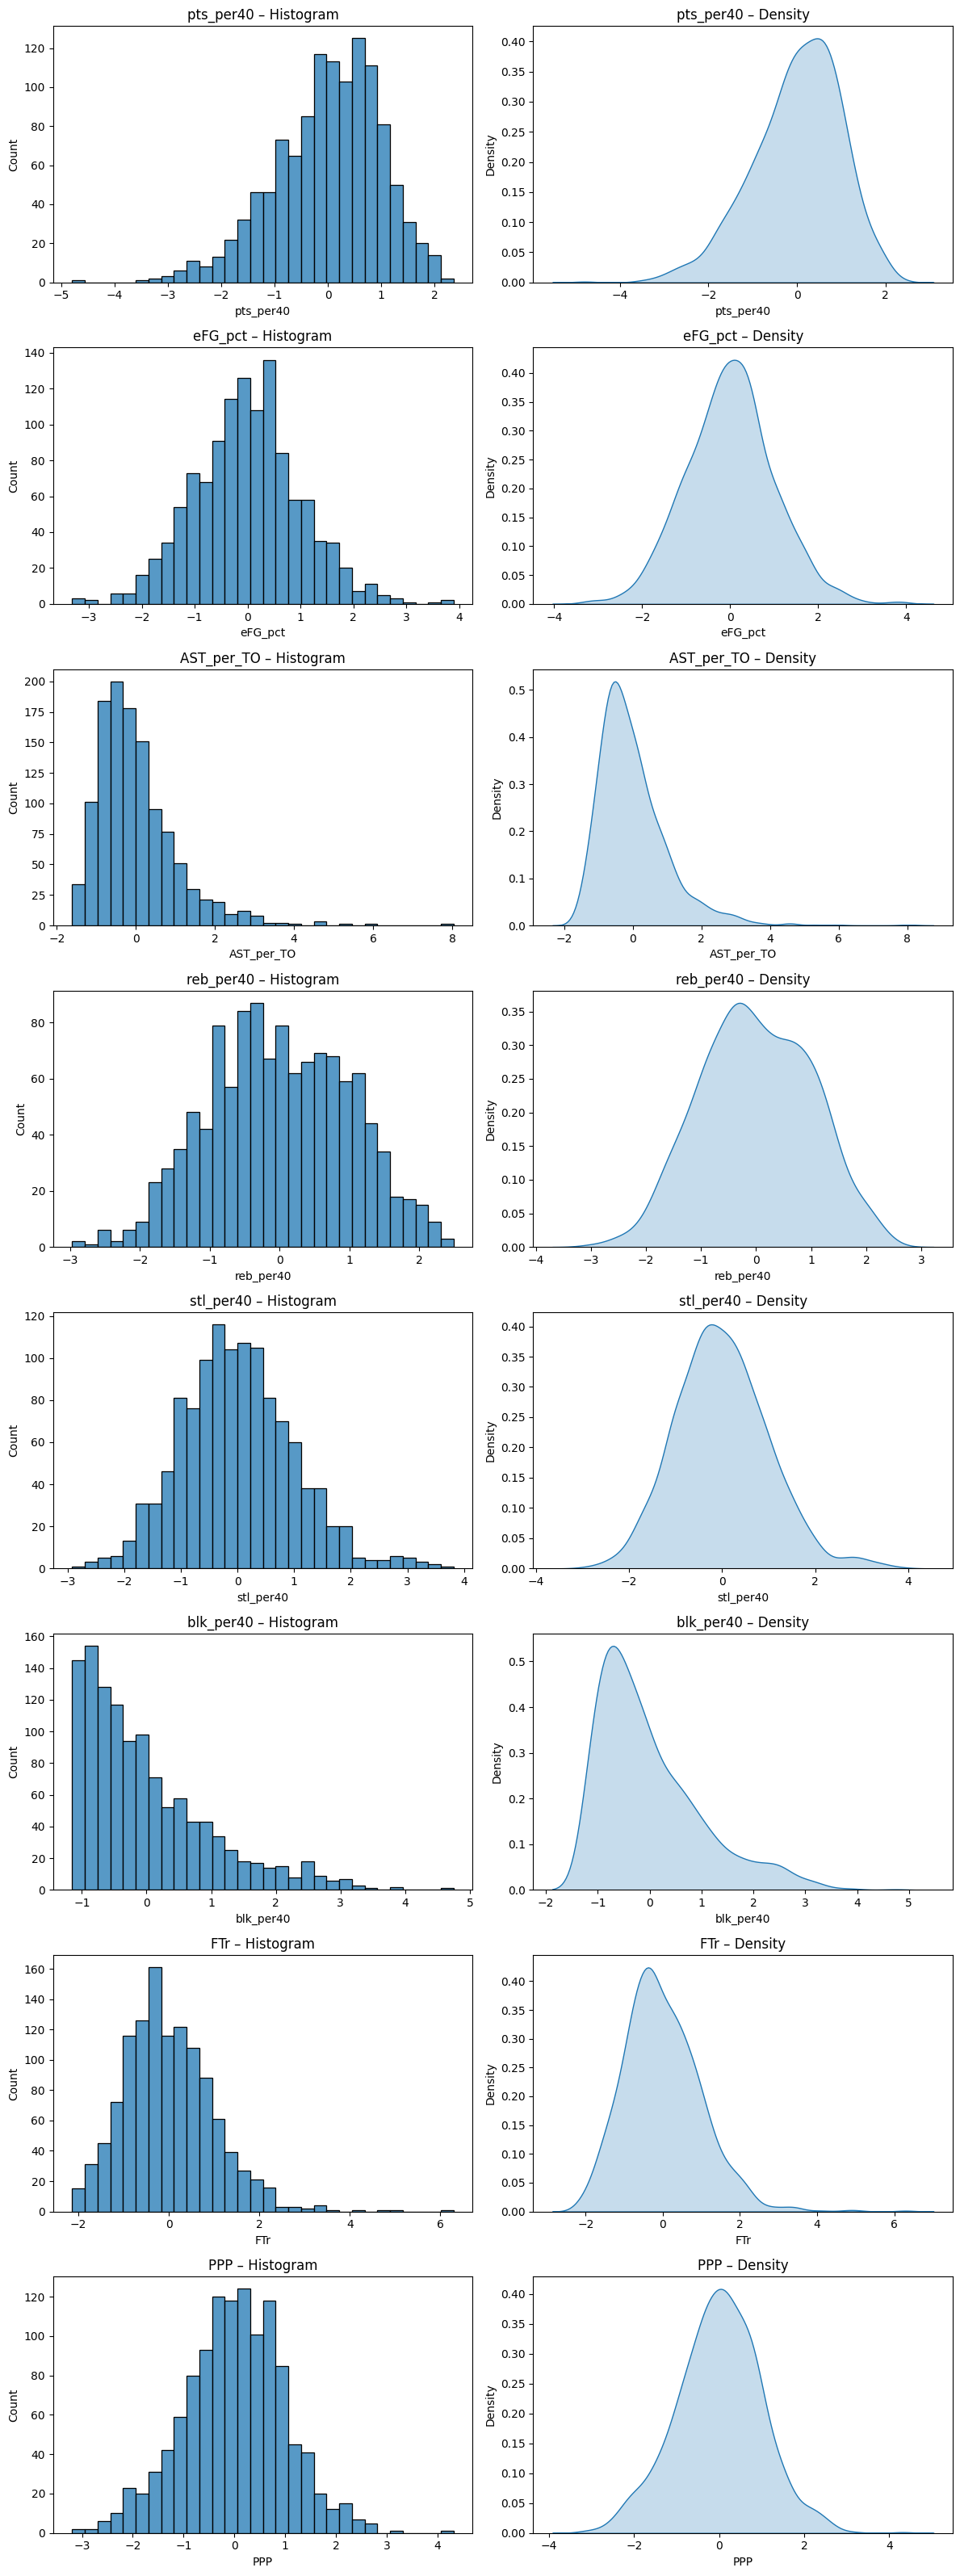

In [72]:
# Histograms & density plots for selected features
features = [
    'pts_per40','eFG_pct','AST_per_TO','reb_per40',
    'stl_per40','blk_per40','FTr','PPP'
]

fig, axes = plt.subplots(len(features), 2, figsize=(12, 4*len(features)))

for ax_row, col in zip(axes, features):
    sns.histplot(df_clean[col], bins=30, ax=ax_row[0], kde=False)
    ax_row[0].set_title(f"{col} – Histogram")
    
    sns.kdeplot(df_clean[col], fill=True, ax=ax_row[1])
    ax_row[1].set_title(f"{col} – Density")

plt.tight_layout()


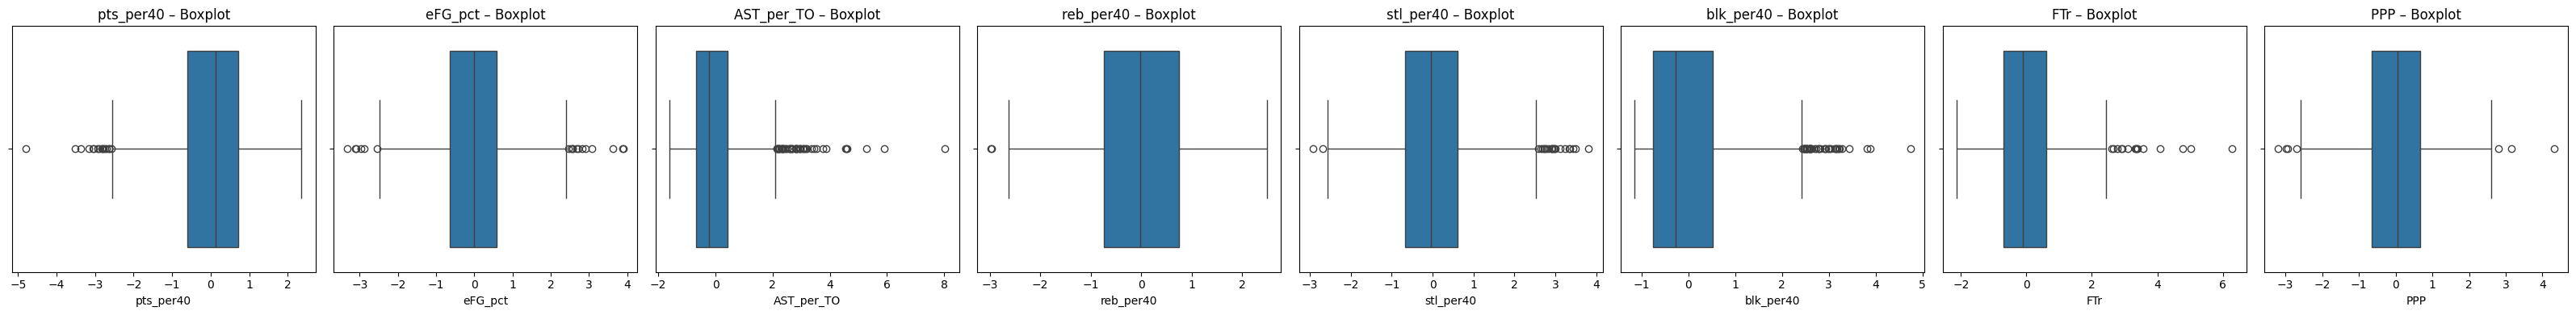

In [73]:
# Boxplots to spot outliers in the same features
fig, axes = plt.subplots(1, len(features), figsize=(4*len(features), 4), sharey=True)

for ax, col in zip(axes, features):
    sns.boxplot(x=df_clean[col], ax=ax)
    ax.set_title(f"{col} – Boxplot")

plt.tight_layout()


**Export Cleaned Dataset**


In [74]:
#export clean dataframe
df_clean.to_csv('df_clean.csv', index=False)
print("df_clean.csv saved, shape:", df_clean.shape)
print("df_clean head:")
print(df_clean.head())

df_clean.csv saved, shape: (1181, 56)
df_clean head:
     college   season  player_number_ind       player_ind    gp_ind    gs_ind  \
0  manhattan  2017-18                 35     Kayla Grimme  0.671799  1.150887   
1  manhattan  2017-18                 15      Amani Tatum  0.671799  1.241175   
2  manhattan  2017-18                  2      Gabby Cajou  0.671799 -1.467469   
3  manhattan  2017-18                 30     Mikki Guiton  0.450675 -0.564588   
4  manhattan  2017-18                 14  Taylor Williams  0.450675  0.518870   

   minutes_tot_ind  scoring_pts_ind  rebounds_tot_ind   ast_ind  ...  \
0         1.199100         2.093976          2.656210 -0.208099  ...   
1         1.569857         1.595968          0.362534  2.833843  ...   
2         1.050798         0.379522         -0.534991  2.020651  ...   
3        -0.749431        -0.485869         -0.568233 -1.051410  ...   
4         0.016799        -0.681807         -0.235816 -0.418927  ...   

   stl_share  blk_share  to

**Correlation Screening**

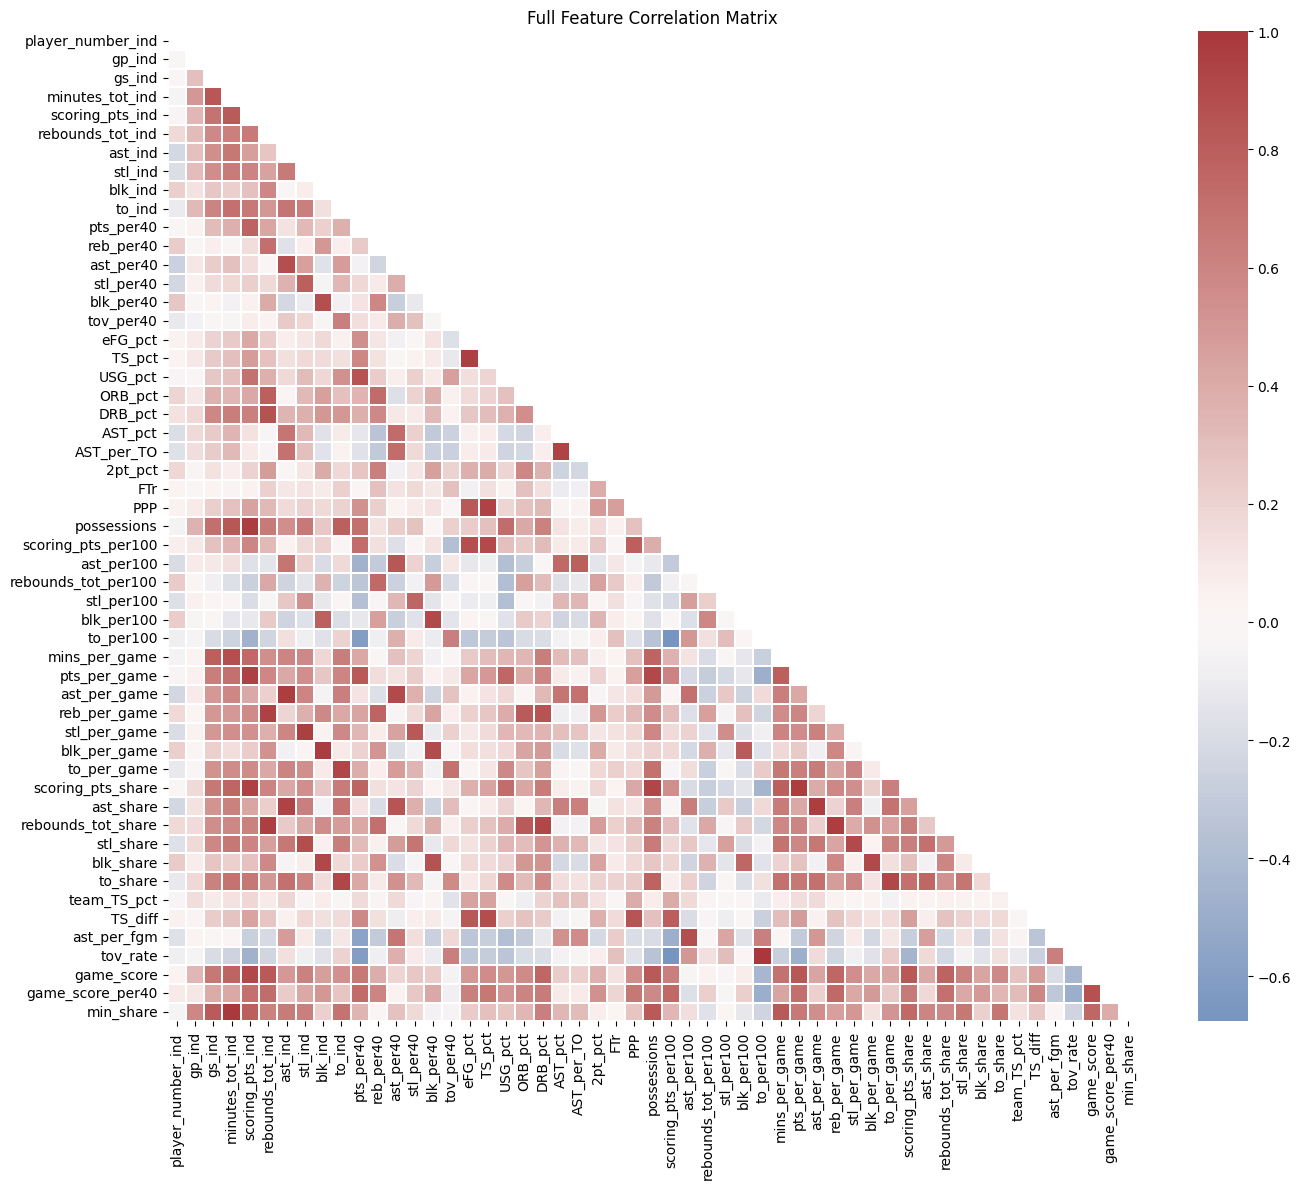

In [75]:
# Correlation Heatmap — full set before dropping
plt.figure(figsize=(14,12))
corr_full = df_clean.select_dtypes(include=[np.number]).corr()
mask = np.triu(np.ones_like(corr_full, dtype=bool))
sns.heatmap(
    corr_full,
    mask=mask,
    cmap='vlag',
    center=0,
    annot=False,
    linewidths=0.3
)
plt.title("Full Feature Correlation Matrix")
plt.tight_layout()


In [76]:
# Greedy Correlation Drop

# threshold
thresh = 0.90

# compute abs corr matrix on your scaled df_clean
numeric = df_clean.select_dtypes(include=[np.number])
corr    = numeric.corr().abs()

# list to hold columns to drop
to_drop = set()

# ordered list of columns
cols = corr.columns.tolist()

# greedy loop: for each (i,j) with j>i, if corr>thresh and j not yet marked, drop j
for i, col_i in enumerate(cols):
    if col_i in to_drop:
        continue
    for col_j in cols[i+1:]:
        if col_j in to_drop:
            continue
        if corr.loc[col_i, col_j] > thresh:
            to_drop.add(col_j)

print(f"Dropping {len(to_drop)} columns:\n", sorted(to_drop))

# now drop them
df_corr = df_clean.drop(columns=to_drop).copy()
print("Shape after greedy drop:", df_corr.shape)


Dropping 18 columns:
 ['AST_per_TO', 'TS_pct', 'ast_per_game', 'ast_share', 'blk_per100', 'blk_per_game', 'blk_share', 'game_score', 'min_share', 'possessions', 'pts_per_game', 'reb_per_game', 'rebounds_tot_share', 'scoring_pts_share', 'stl_per_game', 'to_per_game', 'to_share', 'tov_rate']
Shape after greedy drop: (1181, 38)


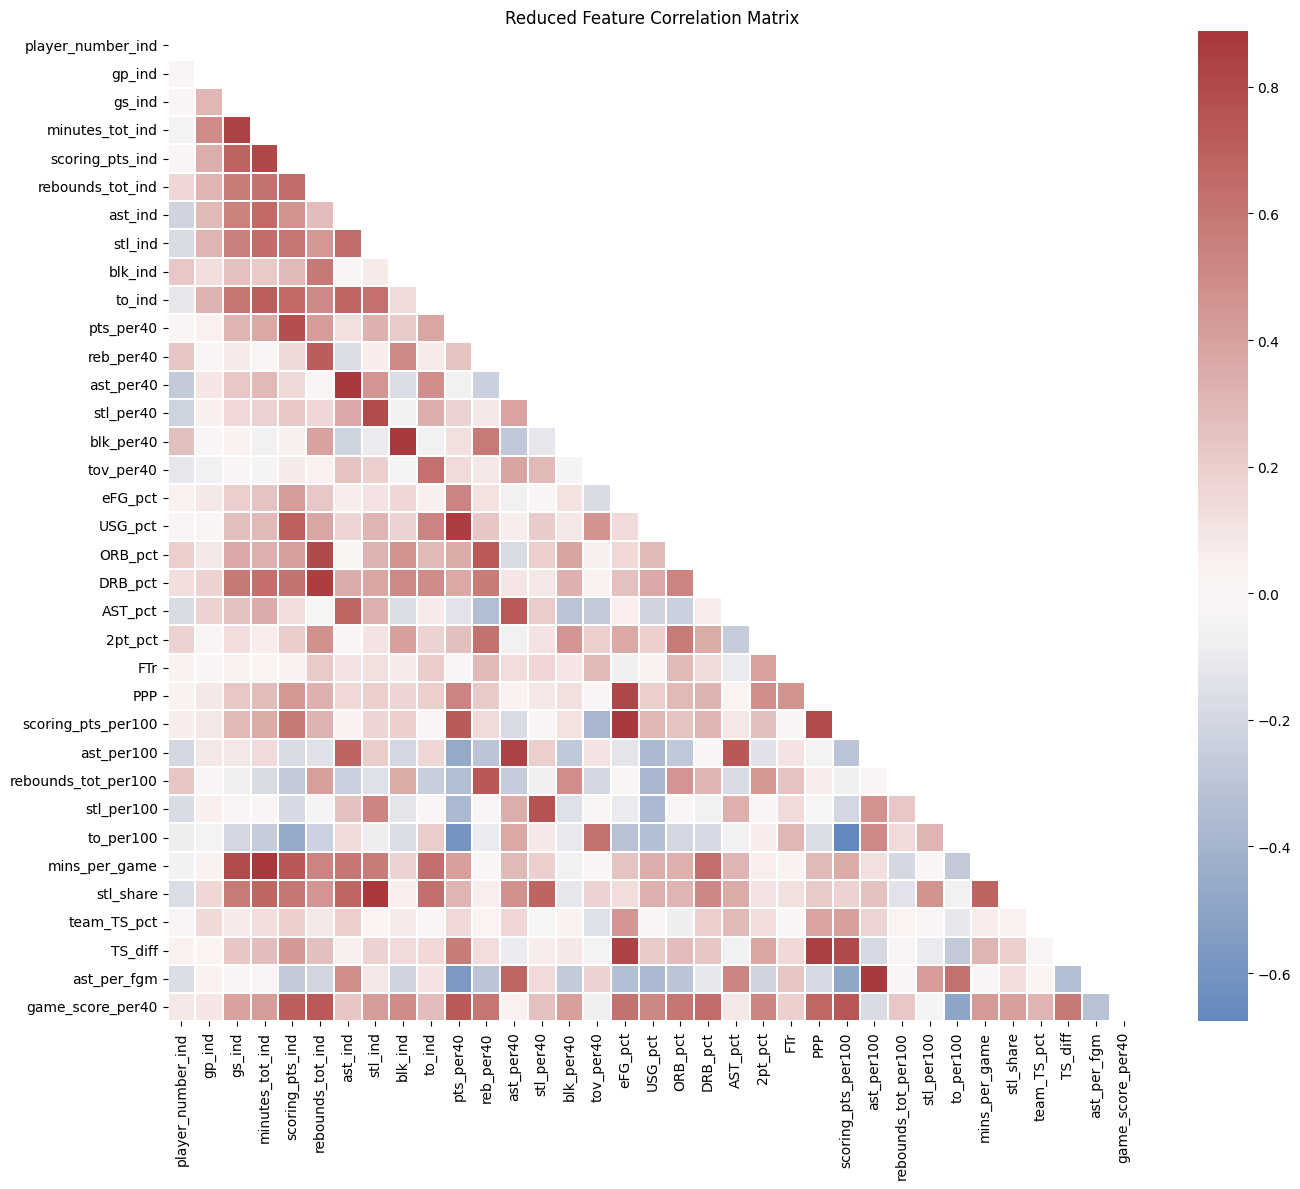

In [77]:
# Correlation Heatmap — after dropping high-corr
plt.figure(figsize=(14,12))
corr_reduced = df_corr.select_dtypes(include=[np.number]).corr()
mask = np.triu(np.ones_like(corr_reduced, dtype=bool))
sns.heatmap(
    corr_reduced,
    mask=mask,
    cmap='vlag',
    center=0,
    annot=False,
    linewidths=0.3
)
plt.title("Reduced Feature Correlation Matrix")
plt.tight_layout()


**Principal Component Analysis (PCA)**

In [78]:
# Fit a full PCA on the filtered & scaled features to inspect variance explained

# identify any identifier columns to exclude from PCA
id_cols = ['player_number_ind', 'player_ind']

# pick numeric feature columns (exclude identifiers)
feat_cols = [
    c for c in df_corr.select_dtypes(include=[np.number]).columns
    if c not in id_cols
]

# fit PCA with as many components as features
pca_full = PCA().fit(df_corr[feat_cols])

# cumulative explained variance
cumvar = np.cumsum(pca_full.explained_variance_ratio_)

# find how many PCs give you at least 90% of variance
n_pc = np.argmax(cumvar >= 0.90) + 1

print(f"Number of components for ≥90% variance: {n_pc}")


Number of components for ≥90% variance: 10


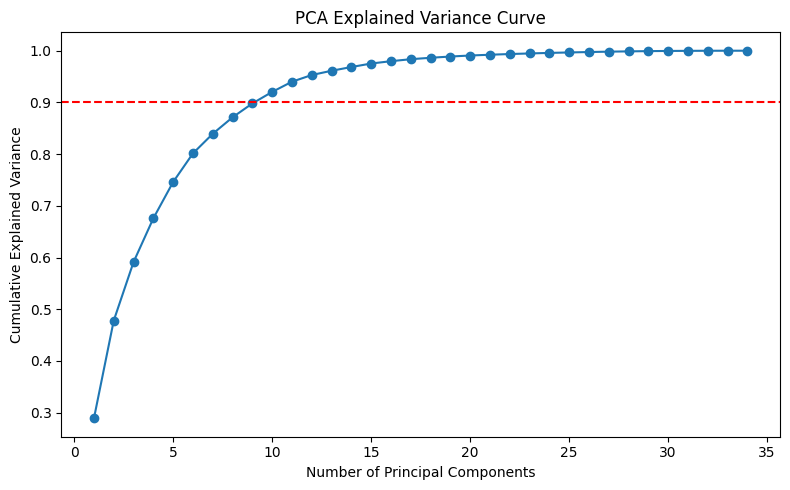

In [79]:
# Plot the cumulative explained‐variance curve (the “elbow” for PCA)

plt.figure(figsize=(8,5))
plt.plot(
    np.arange(1, len(cumvar)+1),
    cumvar,
    marker='o',
    linestyle='-'
)
plt.axhline(0.90, color='red', linestyle='--')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance Curve")
plt.tight_layout()
plt.show()


In [80]:
# Transform your data into the top n_pc principal components

# re‐fit PCA with the chosen number of components
pca = PCA(n_components=n_pc)
pcs = pca.fit_transform(df_corr[feat_cols])

# build a DataFrame of those PCs
pc_cols = [f"PC{i+1}" for i in range(n_pc)]
df_pca = pd.DataFrame(pcs, columns=pc_cols, index=df_corr.index)

# bring along your identifier columns
df_pca[id_cols] = df_corr[id_cols].values

print("df_pca ready with shape:", df_pca.shape)
df_pca.head()


df_pca ready with shape: (1181, 12)


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,player_number_ind,player_ind
0,5.918667,-3.647902,1.782542,1.422488,-2.157467,-1.198568,1.038364,0.045202,0.931962,1.013977,35,Kayla Grimme
1,5.025164,5.225452,-1.289987,-0.208177,0.996782,1.659991,0.106682,0.206678,0.468763,-0.015596,15,Amani Tatum
2,1.904123,4.437600,-0.968827,-2.033994,1.871134,1.771842,0.110613,0.701627,1.383568,0.060497,2,Gabby Cajou
3,-2.140260,-3.037802,-1.121331,0.834883,-0.114817,0.010791,-0.351239,0.933642,-0.770142,-0.001717,30,Mikki Guiton
4,-2.608275,0.458398,-0.864211,-0.084787,-2.703026,0.859593,-0.422904,0.224549,-0.963942,-0.434829,14,Taylor Williams


PCA Validation and Checks

In [81]:
# Tabulate explained‐variance ratios
evr = pca_full.explained_variance_ratio_
cumvar = np.cumsum(evr)

var_df = pd.DataFrame({
    'PC':           [f'PC{i+1}' for i in range(len(evr))],
    'ExplainedVar': evr,
    'CumulativeVar': cumvar
})

print("Explained‐variance ratios:")
display(var_df.style.format({
    'ExplainedVar': '{:.3f}',
    'CumulativeVar':'{:.3f}'
}))


Explained‐variance ratios:


,PC,ExplainedVar,CumulativeVar
0,PC1,0.289,0.289
1,PC2,0.189,0.478
2,PC3,0.113,0.591
3,PC4,0.085,0.676
4,PC5,0.070,0.746
5,PC6,0.055,0.801
6,PC7,0.038,0.839
7,PC8,0.032,0.871
8,PC9,0.027,0.898
9,PC10,0.022,0.920


In [82]:
# Confirm PCs are uncorrelated
pc_corr = df_pca[pc_cols].corr().round(3)
print("Correlation matrix of PCs (should be ≈identity):")
display(pc_corr)


Correlation matrix of PCs (should be ≈identity):


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
PC1,1.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0
PC2,-0.0,1.0,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0
PC3,-0.0,0.0,1.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0
PC4,-0.0,0.0,-0.0,1.0,0.0,-0.0,0.0,-0.0,0.0,0.0
PC5,-0.0,0.0,-0.0,0.0,1.0,0.0,-0.0,0.0,-0.0,0.0
PC6,-0.0,-0.0,-0.0,-0.0,0.0,1.0,-0.0,-0.0,-0.0,-0.0
PC7,-0.0,-0.0,0.0,0.0,-0.0,-0.0,1.0,-0.0,-0.0,0.0
PC8,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,1.0,-0.0,-0.0
PC9,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,1.0,0.0
PC10,-0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,1.0


In [83]:
# Inspect feature loadings for the first two PCs
loadings = pd.DataFrame(
    pca.components_.T,
    index=feat_cols,
    columns=pc_cols
)

for pc in pc_cols[:2]:
    print(f"Top 8 absolute loadings for {pc}:")
    display(
        loadings[pc]
         .abs()
         .sort_values(ascending=False)
         .head(8)
         .rename_axis("feature")
         .reset_index(name="abs_loading")
    )


Top 8 absolute loadings for PC1:


,feature,abs_loading
0,scoring_pts_ind,0.285463
1,game_score_per40,0.274240
2,rebounds_tot_ind,0.258147
3,minutes_tot_ind,0.245858
4,DRB_pct,0.244198
5,pts_per40,0.235681
6,mins_per_game,0.234959
7,gs_ind,0.223703


Top 8 absolute loadings for PC2:


,feature,abs_loading
0,ast_per40,0.335569
1,ast_per100,0.321599
2,ast_ind,0.312289
3,ast_per_fgm,0.296643
4,AST_pct,0.267681
5,stl_share,0.213879
6,stl_ind,0.209285
7,stl_per100,0.204704


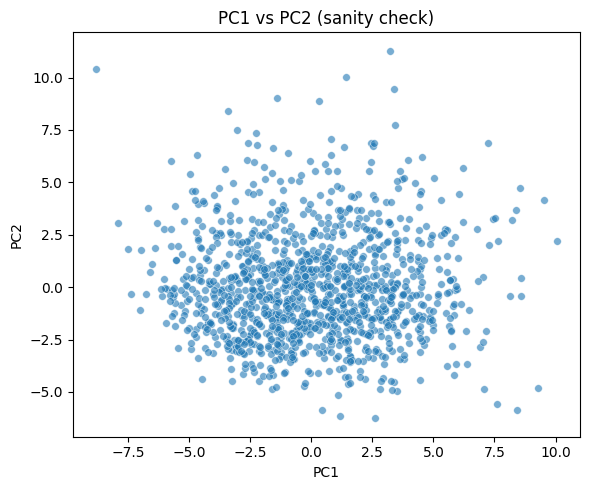

In [84]:
# Quick PC1 vs PC2 scatter
plt.figure(figsize=(6,5))
sns.scatterplot(x='PC1', y='PC2', data=df_pca, s=30, alpha=0.6)
plt.title("PC1 vs PC2 (sanity check)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.tight_layout()
plt.show()


**Export PCA Dataset to CSV**

In [85]:
#export pca dataframe
df_pca.to_csv('df_pca.csv', index=True)
print("df_pca.csv saved, shape:", df_pca.shape)
print("df_pca head:")
print(df_pca.head())

df_pca.csv saved, shape: (1181, 12)
df_pca head:
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  5.918667 -3.647902  1.782542  1.422488 -2.157467 -1.198568  1.038364   
1  5.025164  5.225452 -1.289987 -0.208177  0.996782  1.659991  0.106682   
2  1.904123  4.437600 -0.968827 -2.033994  1.871134  1.771842  0.110613   
3 -2.140260 -3.037802 -1.121331  0.834883 -0.114817  0.010791 -0.351239   
4 -2.608275  0.458398 -0.864211 -0.084787 -2.703026  0.859593 -0.422904   

        PC8       PC9      PC10 player_number_ind       player_ind  
0  0.045202  0.931962  1.013977                35     Kayla Grimme  
1  0.206678  0.468763 -0.015596                15      Amani Tatum  
2  0.701627  1.383568  0.060497                 2      Gabby Cajou  
3  0.933642 -0.770142 -0.001717                30     Mikki Guiton  
4  0.224549 -0.963942 -0.434829                14  Taylor Williams  
